# Installs

In [ ]:
!pip install tensorboardX

# Imports

In [ ]:
import gym
import torch
import torch.nn as nn
from itertools import count
from torch.distributions import Bernoulli
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Policy Network

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.relu(x)
        x = self.sigmoid(self.fc3(x))
        return x

    def select_action(self, state):
        with torch.no_grad():
            prob = self.forward(state)
            b = Bernoulli(prob)
            action = b.sample()
        return action.item()

# Value Network

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Problem Parameters

In [ ]:
env = gym.make('CartPole-v0')
policy = PolicyNetwork().to(device)
value = ValueNetwork().to(device)
optim = torch.optim.Adam(policy.parameters(), lr=1e-4)
value_optim = torch.optim.Adam(value.parameters(), lr=3e-4)
gamma = 0.99
writer = SummaryWriter('./fc_logs')
steps = 0
episode_rewards_list = []

In [ ]:
for epoch in range(5000): # 5000 episodes
        state = env.reset()
        state = np.delete(state, 1) # Delete cart velocity
        state = np.delete(state, 2) # Delete pole velocity
        episode_reward = 0

        rewards = []
        actions = []
        states = []

        for time_steps in range(200): # 200 horizon
            states.append(state)
            state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
            action = policy.select_action(state)
            actions.append(int(action))
            next_state, reward, done, _ = env.step(int(action))
            next_state = np.delete(next_state, 1)
            next_state = np.delete(next_state, 2)
            episode_reward += reward
            state = next_state
            rewards.append(reward)
            if done:
                break

        R = 0
        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            rewards[i] = R

        rewards_mean = np.mean(rewards)
        rewards_std = np.std(rewards)
        rewards = (rewards - rewards_mean) / rewards_std

        states_tensor = torch.FloatTensor(states).to(device)
        actions_tensor = torch.FloatTensor(actions).unsqueeze(1).to(device)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(device)

        with torch.no_grad():
            v = value(states_tensor)
            advantage = rewards_tensor - v

        prob = policy(states_tensor)
        b = Bernoulli(prob)
        log_prob = b.log_prob(actions_tensor)
        loss = - log_prob * advantage
        loss = loss.mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        writer.add_scalar('action loss', loss.item(), epoch)

        v = value(states_tensor)
        value_loss = F.mse_loss(rewards_tensor, v)

        value_optim.zero_grad()
        value_loss.backward()
        value_optim.step()
        writer.add_scalar('value loss', value_loss.item(), epoch)

        writer.add_scalar('episode reward', episode_reward, epoch)
        episode_rewards_list.append(episode_reward)
        if epoch % 10 == 0:
            print('Epoch:{}, episode reward is {}'.format(epoch, episode_reward))
            torch.save(policy.state_dict(), 'fc-policy.para')

Epoch:0, episode reward is 50.0
Epoch:10, episode reward is 11.0
Epoch:20, episode reward is 19.0
Epoch:30, episode reward is 12.0
Epoch:40, episode reward is 31.0
Epoch:50, episode reward is 22.0
Epoch:60, episode reward is 60.0
Epoch:70, episode reward is 13.0
Epoch:80, episode reward is 17.0
Epoch:90, episode reward is 12.0
Epoch:100, episode reward is 20.0
Epoch:110, episode reward is 13.0
Epoch:120, episode reward is 27.0
Epoch:130, episode reward is 27.0
Epoch:140, episode reward is 25.0
Epoch:150, episode reward is 19.0
Epoch:160, episode reward is 13.0
Epoch:170, episode reward is 17.0
Epoch:180, episode reward is 21.0
Epoch:190, episode reward is 15.0
Epoch:200, episode reward is 15.0
Epoch:210, episode reward is 9.0
Epoch:220, episode reward is 31.0
Epoch:230, episode reward is 21.0
Epoch:240, episode reward is 19.0
Epoch:250, episode reward is 25.0
Epoch:260, episode reward is 13.0
Epoch:270, episode reward is 22.0
Epoch:280, episode reward is 40.0
Epoch:290, episode reward 

In [ ]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [ ]:
episode_rewards_array = np.array(episode_rewards_list)
avg_reward_array = running_mean(episode_rewards_array, 50)

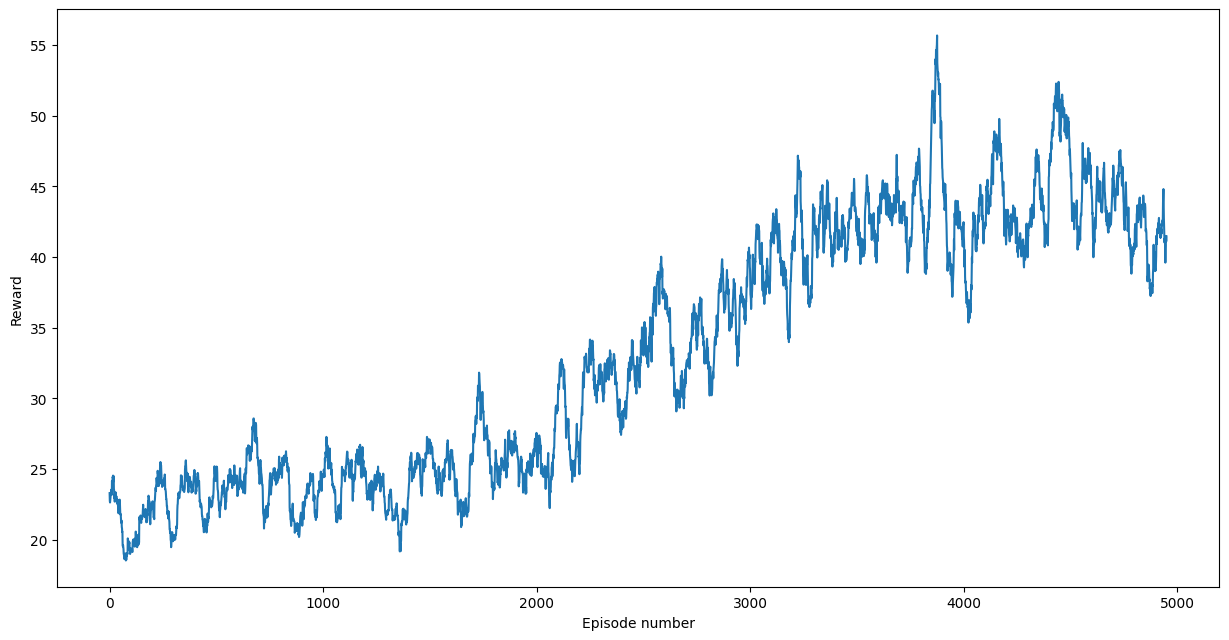

In [ ]:
plt.figure(figsize=(15, 7.5))
plt.plot(avg_reward_array)
plt.xlabel('Episode number')
plt.ylabel('Reward')
plt.show()

# LSTM

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.lstm = nn.LSTM(64, 128, batch_first=True) # LSTM
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        x = self.relu(self.fc1(x))
        x, hidden = self.lstm(x, hidden)
        x = self.relu(x)
        x = self.sigmoid(self.fc2(x))
        return x, hidden

    def select_action(self, state, hidden):
        with torch.no_grad():
            prob, hidden = self.forward(state, hidden)
            b = Bernoulli(prob)
            action = b.sample()
        return action.item(), hidden

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(2, 64)
        self.lstm = nn.LSTM(64, 256, batch_first=True) #LSTM
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x, hidden):
        x = self.relu(self.fc1(x))
        x, hidden = self.lstm(x, hidden)
        x = self.relu(x)
        x = self.fc2(x)
        return x, hidden

In [ ]:
env = gym.make('CartPole-v0')
policy = PolicyNetwork().to(device)
value = ValueNetwork().to(device)
optim = torch.optim.Adam(policy.parameters(), lr=1e-4)
value_optim = torch.optim.Adam(value.parameters(), lr=3e-4)
gamma = 0.99
writer = SummaryWriter('./lstm_logs')
steps = 0
episode_rewards_list = []

In [ ]:
for epoch in range(5000): # 5000 episodes
        state = env.reset()
        state = np.delete(state, 1) # Delete cart velocity
        state = np.delete(state, 2) # Delete pole velocity
        episode_reward = 0

        a_hx = torch.zeros((1, 1, 128)).to(device)
        a_cx = torch.zeros((1, 1, 128)).to(device)

        rewards = []
        actions = []
        states = []

        for time_steps in range(200): # 200 horizon
            states.append(state)
            state = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
            action, (a_hx, a_cx) = policy.select_action(state, (a_hx, a_cx))
            actions.append(int(action))
            next_state, reward, done, _ = env.step(int(action))
            next_state = np.delete(next_state, 1)
            next_state = np.delete(next_state, 2)
            episode_reward += reward
            state = next_state
            rewards.append(reward)
            if done:
                break

        R = 0
        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            rewards[i] = R

        rewards_mean = np.mean(rewards)
        rewards_std = np.std(rewards)
        rewards = (rewards - rewards_mean) / rewards_std

        states_tensor = torch.FloatTensor(states).unsqueeze(0).to(device)
        actions_tensor = torch.FloatTensor(actions).unsqueeze(1).to(device)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(device)

        with torch.no_grad():
            c_hx = torch.zeros((1, 1, 256)).to(device)
            c_cx = torch.zeros((1, 1, 256)).to(device)
            v, v_hidden = value(states_tensor, (c_hx, c_cx))
            v = v.squeeze(0)
            advantage = rewards_tensor - v

        a_hx = torch.zeros((1, 1, 128)).to(device)
        a_cx = torch.zeros((1, 1, 128)).to(device)

        prob, a_hidden = policy(states_tensor, (a_hx, a_cx))
        prob = prob.squeeze(0)
        b = Bernoulli(prob)
        log_prob = b.log_prob(actions_tensor)
        loss = - log_prob * advantage
        loss = loss.mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        writer.add_scalar('action loss', loss.item(), epoch)

        c_hx = torch.zeros((1, 1, 256)).to(device)
        c_cx = torch.zeros((1, 1, 256)).to(device)
        v, v_hidden = value(states_tensor, (c_hx, c_cx))
        v = v.squeeze(0)
        value_loss = F.mse_loss(rewards_tensor, v)
        value_optim.zero_grad()
        value_loss.backward()
        value_optim.step()
        writer.add_scalar('value loss', value_loss.item(), epoch)

        writer.add_scalar('episode reward', episode_reward, epoch)
        episode_rewards_list.append(episode_reward)
        if epoch % 10 == 0:
            print('Epoch:{}, episode reward is {}'.format(epoch, episode_reward))
            torch.save(policy.state_dict(), 'lstm-policy.para')

Epoch:0, episode reward is 11.0
Epoch:10, episode reward is 20.0
Epoch:20, episode reward is 23.0
Epoch:30, episode reward is 14.0
Epoch:40, episode reward is 22.0
Epoch:50, episode reward is 11.0
Epoch:60, episode reward is 14.0
Epoch:70, episode reward is 24.0
Epoch:80, episode reward is 12.0
Epoch:90, episode reward is 23.0
Epoch:100, episode reward is 10.0
Epoch:110, episode reward is 19.0
Epoch:120, episode reward is 30.0
Epoch:130, episode reward is 11.0
Epoch:140, episode reward is 15.0
Epoch:150, episode reward is 12.0
Epoch:160, episode reward is 47.0
Epoch:170, episode reward is 20.0
Epoch:180, episode reward is 14.0
Epoch:190, episode reward is 11.0
Epoch:200, episode reward is 10.0
Epoch:210, episode reward is 47.0
Epoch:220, episode reward is 11.0
Epoch:230, episode reward is 16.0
Epoch:240, episode reward is 14.0
Epoch:250, episode reward is 30.0
Epoch:260, episode reward is 22.0
Epoch:270, episode reward is 28.0
Epoch:280, episode reward is 20.0
Epoch:290, episode reward

In [ ]:
episode_rewards_array = np.array(episode_rewards_list)
avg_reward_array = running_mean(episode_rewards_array, 50)

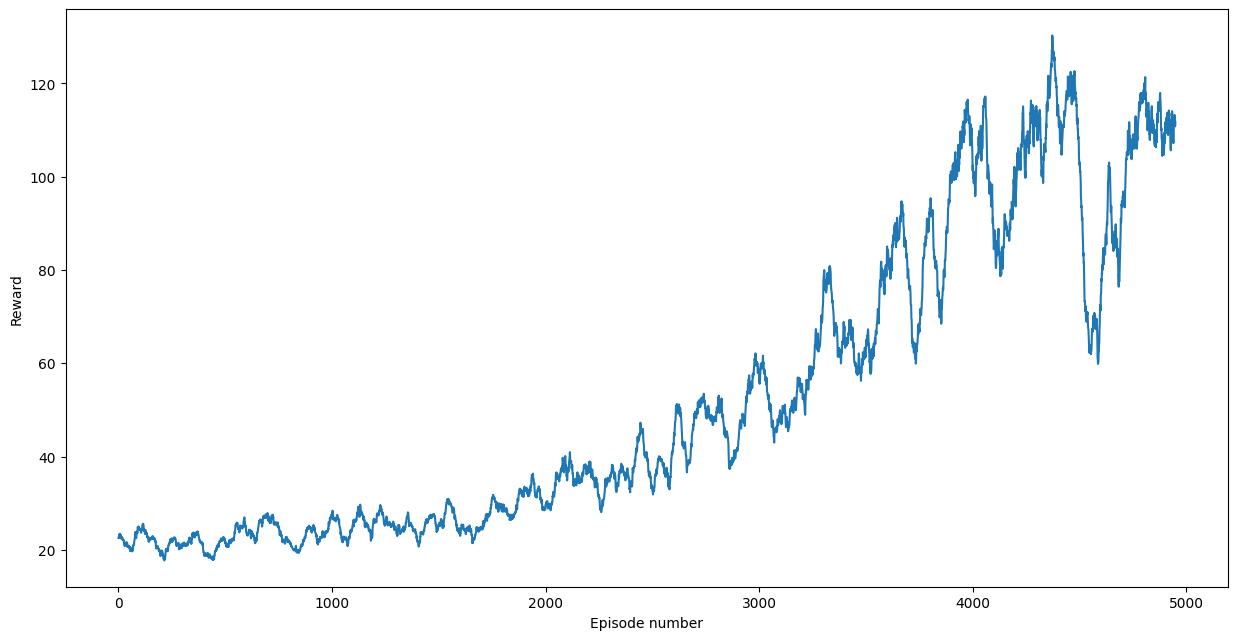

In [ ]:
plt.figure(figsize=(15, 7.5))
plt.plot(avg_reward_array)
plt.xlabel('Episode number')
plt.ylabel('Reward')
plt.show()